## Modeling NLP (Reply)

In [1]:
pip install nest_asyncio

In [2]:
pip install Sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.1 MB/s eta 0:00:00


In [3]:
pip install scikeras

In [4]:
!apt-get -qq install -y libfluidsynth1

E: Package 'libfluidsynth1' has no installation candidate


In [5]:
#import some libraries

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    classification_report,
)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
reply_train=pd.read_excel('/content/drive/MyDrive/Reply Training Model.xlsx')
reply_test=pd.read_excel('/content/drive/MyDrive/Reply Testing Model.xlsx')

reply=pd.concat([reply_train, reply_test], axis=0)
reply.reset_index(drop=True, inplace=True)
reply

,username,created_at,text_clean,text_eng,Positive,Negative,Neutral,Compound,Sentiment,text_preprocessed
0,sarkowi_namaku,2023-11-12 23:55:22,tenang tenang ada bapak,"calm down, calm down, daddy'",0.605,0.000,0.395,0.5574,positif,"['tenang', 'tenang']"
1,BullshitBoss1,2023-11-12 23:24:41,dengan adanya dukungan dan kekuatan dari rakya...,with the support and strength of the Indonesia...,0.508,0.000,0.492,0.9081,positif,"['dukung', 'kuat', 'rakyat', 'indonesia', 'gan..."
2,HansItta11,2023-11-12 23:23:07,anak karbitan yang tahu malu persis pohonnya,a shameless carbitan child exactly the tree',0.000,0.324,0.676,-0.3400,negatif,"['anak', 'karbitan', 'malu', 'persis', 'pohon']"
3,freyadaniella79,2023-11-12 22:56:21,harus yakin,must be sure',0.535,0.000,0.465,0.3182,negatif,[]
4,chy915060246419,2023-11-12 22:38:55,ganjar mahfud pasti menang,reward Mahfud will definitely win',0.836,0.000,0.164,0.8807,positif,"['ganjar', 'mahfud', 'menang']"
...,...,...,...,...,...,...,...,...,...,...
11023,ariefpost,2023-05-15 10:33:36,ga usah survei yang menang pasti orang jawa,"Don't need a survey, the winner will definitel...",0.481,0.000,0.519,0.7579,positif,"['ga', 'survei', 'menang', 'orang', 'jawa']"
11024,SandhiCimot,2023-05-15 09:57:31,survey itu dibikin supaya pemilih tau jagoanny...,surveys are made so that voters know whether t...,0.235,0.159,0.606,0.5499,positif,"['survey', 'bikin', 'pilih', 'tau', 'jago', 'm..."
11025,Warnilisssn,2023-05-15 09:12:43,waduh jagoan gue ketinggalan truss pusiing dac...,oh my hero missed out and then I'm confused ab...,0.178,0.376,0.446,-0.4588,negatif,"['jago', 'gue', 'tinggal', 'truss', 'pusiing',..."
11026,Poordad9,2023-05-15 08:58:44,ga usah survay survey sudah ketebak hasilnya,"Don't take a survey, you can already guess the...",0.000,0.000,1.000,0.0000,negatif,"['ga', 'survay', 'survey', 'tebak', 'hasil']"


In [8]:
reply_train.shape

(8066, 10)

In [9]:
reply_test.shape

(2962, 10)

### TF-IDF

In [10]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

X_clean=reply['text_clean']

# Inisialisasi TfidfVectorizer
stop_words = set(stopwords.words('indonesian'))
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords.words('indonesian'))

# Fit dan transform teks menjadi representasi TF-IDF
# X
X = tfidf_vectorizer.fit_transform(X_clean)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn(


In [11]:
X.shape

(11028, 16188)

### Train-Test Split

In [12]:
from scipy.sparse import csr_matrix

X_train = X[:len(reply_train)]
X_test = X[len(reply_train):]

In [13]:
X_train.shape

(8066, 16188)

In [14]:
X_test.shape

(2962, 16188)

In [15]:
# y
polarity_encode={'negatif':0, 'netral':1, 'positif':2}
y=reply['Sentiment'].map(polarity_encode)
y

0        2
1        2
2        0
3        0
4        2
        ..
11023    2
11024    2
11025    0
11026    0
11027    0
Name: Sentiment, Length: 11028, dtype: int64

In [16]:
y.shape

(11028,)

In [17]:
y_train = y[:len(reply_train)]
y_test = y[len(reply_train):]

In [18]:
y_train.shape

(8066,)

In [19]:
y_test.shape

(2962,)

In [20]:
# y_test.reset_index(drop=True, inplace=True)

### Imbalance Data

#### Train

In [ ]:
reply_train.Sentiment.value_counts()

negatif    5139
positif    1983
netral      944
Name: Sentiment, dtype: int64

<Axes: xlabel='Sentiment', ylabel='count'>

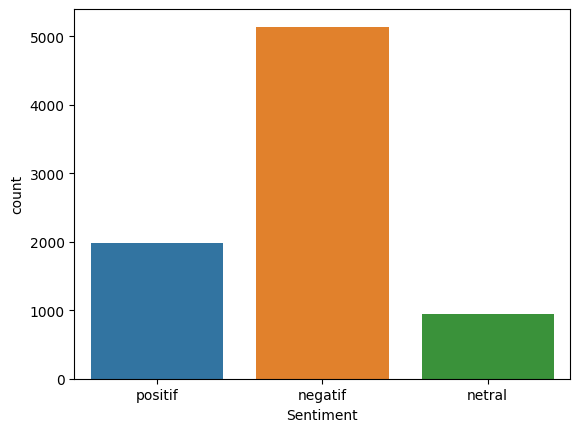

In [ ]:
sns.countplot(x='Sentiment', data=reply_train)

In [21]:
X_res_train, y_res_train = SMOTE().fit_resample (X_train, y_train)
y_res_train.value_counts()

2    5139
0    5139
1    5139
Name: Sentiment, dtype: int64

<Axes: ylabel='count'>

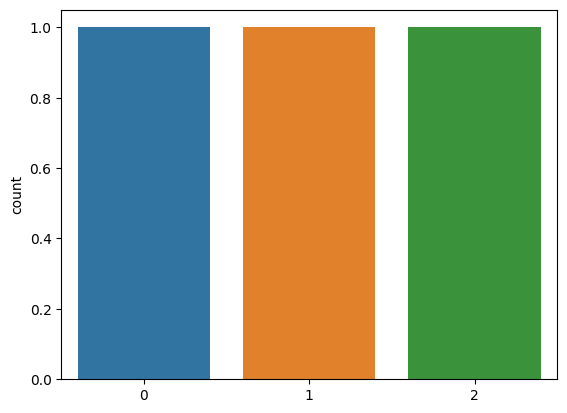

In [22]:
data = {
    1: 5139,
    2: 5139,
    0: 5139
}

# Konversi data ke dalam bentuk yang dapat diplot
categories = list(data.keys())
counts = list(data.values())

# Membuat countplot dengan seaborn
sns.countplot(x=categories)

In [23]:
X_res_train.shape

(15417, 16188)

In [ ]:
y_res_train.shape

(15417,)

#### Test

In [ ]:
reply_test.Sentiment.value_counts()

negatif    1794
positif     724
netral      444
Name: Sentiment, dtype: int64

<Axes: xlabel='Sentiment', ylabel='count'>

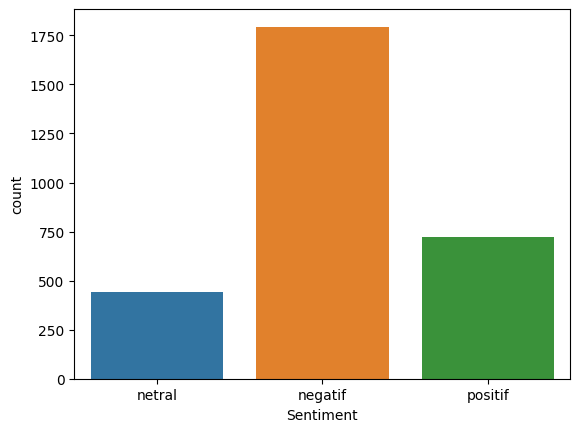

In [ ]:
sns.countplot(x='Sentiment', data=reply_test)

In [ ]:
X_res_test, y_res_test = SMOTE().fit_resample (X_test, y_test)
y_res_test.value_counts()

1    1794
0    1794
2    1794
Name: Sentiment, dtype: int64

<Axes: ylabel='count'>

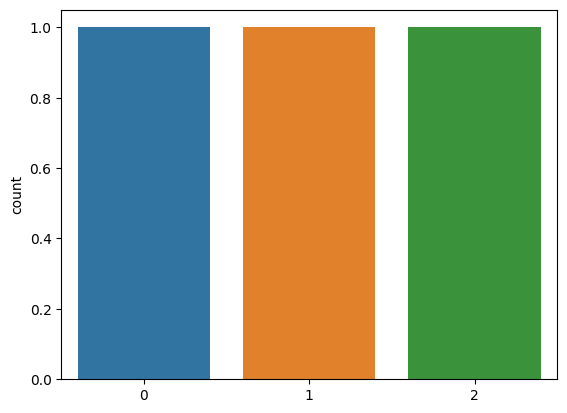

In [24]:
data = {
    1: 1794,
    2: 1794,
    0: 1794
}

# Konversi data ke dalam bentuk yang dapat diplot
categories = list(data.keys())
counts = list(data.values())

# Membuat countplot dengan seaborn
sns.countplot(x=categories)

In [ ]:
X_res_test.shape

(5382, 16188)

In [ ]:
y_res_test.shape

(5382,)

### SVM

In [ ]:
# SVM

svm_model = SVC()

svm_model.fit(X_train, y_train)
y_pred_train = svm_model.predict(X_train)
y_pred_test = svm_model.predict(X_test)

accuracy_train = accuracy_score(y_pred_train, y_train)
accuracy_test = accuracy_score(y_pred_test, y_test)
f1_train = f1_score(y_pred_train, y_train, average="weighted")
f1_test = f1_score(y_pred_test, y_test, average="weighted")

print("Accuracy Train : ", accuracy_train)
print("Accuracy Test : ", accuracy_test)
print("F1 Score Train : ", f1_train)
print("F1 Score Test : ", f1_test)

Accuracy Train :  0.9073890404165633
Accuracy Test :  0.6610398379473329
F1 Score Train :  0.9169664824393589
F1 Score Test :  0.743800569710521


In [ ]:
# SVM After Balancing Data

svm_model = SVC()

svm_model.fit(X_res_train, y_res_train)
y_pred_train = svm_model.predict(X_res_train)
y_pred_test = svm_model.predict(X_res_test)

accuracy_train = accuracy_score(y_pred_train, y_res_train)
accuracy_test = accuracy_score(y_pred_test, y_res_test)
f1_train = f1_score(y_pred_train, y_res_train, average="weighted")
f1_test = f1_score(y_pred_test, y_res_test, average="weighted")

print("Accuracy Train : ", accuracy_train)
print("Accuracy Test : ", accuracy_test)
print("F1 Score Train : ", f1_train)
print("F1 Score Test : ", f1_test)

Accuracy Train :  0.9911785691120192
Accuracy Test :  0.5875139353400223
F1 Score Train :  0.9911656542204612
F1 Score Test :  0.6297077209388272


### Random Forest

In [ ]:
# Random

rfc = RandomForestClassifier()

rfc.fit(X_train, y_train)
y_pred_train = rfc.predict(X_train)
y_pred_test = rfc.predict(X_test)

accuracy_train = accuracy_score(y_pred_train, y_train)
accuracy_test = accuracy_score(y_pred_test, y_test)
f1_train = f1_score(y_pred_train, y_train, average="weighted")
f1_test = f1_score(y_pred_test, y_test, average="weighted")

print("Accuracy Train : ", accuracy_train)
print("Accuracy Test : ", accuracy_test)
print("F1 Score Train : ", f1_train)
print("F1 Score Test : ", f1_test)

Accuracy Train :  0.9995040912472105
Accuracy Test :  0.6748818365968939
F1 Score Train :  0.9995041654429496
F1 Score Test :  0.7277582520268487


In [ ]:
# Random Forest After Balancing Data

rfc = RandomForestClassifier()

rfc.fit(X_res_train, y_res_train)
y_pred_train = rfc.predict(X_res_train)
y_pred_test = rfc.predict(X_res_test)

accuracy_train = accuracy_score(y_pred_train, y_res_train)
accuracy_test = accuracy_score(y_pred_test, y_res_test)
f1_train = f1_score(y_pred_train, y_res_train, average="weighted")
f1_test = f1_score(y_pred_test, y_res_test, average="weighted")

print("Accuracy Train : ", accuracy_train)
print("Accuracy Test : ", accuracy_test)
print("F1 Score Train : ", f1_train)
print("F1 Score Test : ", f1_test)

Accuracy Train :  0.9997405461503535
Accuracy Test :  0.5490523968784838
F1 Score Train :  0.9997405587783007
F1 Score Test :  0.5849593951558176


### XGBoost

In [ ]:
# XGBoost

xgb = XGBClassifier()

xgb.fit(X_train, y_train)
y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)

accuracy_train = accuracy_score(y_pred_train, y_train)
accuracy_test = accuracy_score(y_pred_test, y_test)
f1_train = f1_score(y_pred_train, y_train, average="weighted")
f1_test = f1_score(y_pred_test, y_test, average="weighted")

print("Accuracy Train : ", accuracy_train)
print("Accuracy Test : ", accuracy_test)
print("F1 Score Train : ", f1_train)
print("F1 Score Test : ", f1_test)

Accuracy Train :  0.7902611534276387
Accuracy Test :  0.42165592058131207
F1 Score Train :  0.8198163249673436
F1 Score Test :  0.380500258698432


In [ ]:
# XGBoost After Balancing Data

xgb = XGBClassifier()

xgb.fit(X_res_train, y_res_train)
y_pred_train = xgb.predict(X_res_train)
y_pred_test = xgb.predict(X_res_test)

accuracy_train = accuracy_score(y_pred_train, y_res_train)
accuracy_test = accuracy_score(y_pred_test, y_res_test)
f1_train = f1_score(y_pred_train, y_res_train, average="weighted")
f1_test = f1_score(y_pred_test, y_res_test, average="weighted")

print("Accuracy Train : ", accuracy_train)
print("Accuracy Test : ", accuracy_test)
print("F1 Score Train : ", f1_train)
print("F1 Score Test : ", f1_test)

Accuracy Train :  0.8646948174093533
Accuracy Test :  0.6034931252322556
F1 Score Train :  0.8641074250745903
F1 Score Test :  0.6208081428578323


Dari ketiga model tersebut pada masing-masing model membandingkan matrics score antara menggunakan data asli dan juga data yang sudah dilakukan balancing.
Secara overall data asli (tanpa balancing) menghasilkan akurasi yang lebih baik.

Kemudian dari ketiga model tersebut dipilih model SVM karena model tersebut yang memiliki nilai F-Score yang lebih dekat jaraknya antara F-Score training dan testing dibandingkan model lainnya sehingga selanjutnya dilakukan hyperparameter tuning supaya mendapatkan hasil akurasi yang lebih maksimal

### Hyperparameter Tuning

In [ ]:
#GridSearch
from sklearn.model_selection import GridSearchCV

#Cross Validation -> Untuk menangani data yang tidak balance
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold

#Evaluation
from sklearn import metrics
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.metrics import make_scorer,accuracy_score,roc_auc_score,precision_score,recall_score,f1_score,log_loss
from sklearn.metrics import confusion_matrix

#### SVM

In [ ]:
#Best Model SVC
svc = SVC()
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','linear', 'sigmoid', 'poly']}
grid=GridSearchCV(svc, param_grid, cv = StratifiedKFold(n_splits=5), n_jobs=-1, verbose=4)

In [ ]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear', 'sigmoid', 'poly']},
             verbose=4)

In [ ]:
print(grid.best_params_)
print(grid.best_estimator_)

{'C': 1, 'gamma': 1, 'kernel': 'linear'}
SVC(C=1, gamma=1, kernel='linear')


#### Best Model SVM

In [ ]:
# SVC (Hyperparameter Tuning)

svm_model = SVC(C=1, gamma=1, kernel='linear')

svm_model.fit(X_train, y_train)
y_pred_train = svm_model.predict(X_train)
y_pred_test = svm_model.predict(X_test)

accuracy_train = accuracy_score(y_pred_train, y_train)
accuracy_test = accuracy_score(y_pred_test, y_test)
f1_train = f1_score(y_pred_train, y_train, average="weighted")
f1_test = f1_score(y_pred_test, y_test, average="weighted")
precision_train = precision_score(y_pred_train, y_train, average='weighted')
precision_test = precision_score(y_pred_test, y_test, average='weighted')
recall_train = recall_score(y_pred_train, y_train, average='weighted')
recall_test = recall_score(y_pred_test, y_test, average='weighted')

print("Accuracy Train : ", accuracy_train)
print("Accuracy Test : ", accuracy_test)
print("Precision Train : ", precision_train)
print("Precision Test : ", precision_test)
print("Recall Train : ", recall_train)
print("Recall Test : ", recall_test)

print("\nF1 Score Train : ", f1_train)
print("F1 Score Test : ", f1_test)

Accuracy Train :  0.844532606000496
Accuracy Test :  0.673869007427414
Precision Train :  0.9048972195155225
Precision Test :  0.8386731023718217
Recall Train :  0.844532606000496
Recall Test :  0.673869007427414

F1 Score Train :  0.8633398930100906
F1 Score Test :  0.733848952206421


Setelah hyperparameter tuning diperoleh nilai F1-Score yang turun tetapi model yang telah dihyperparameter tuning merupakan model terpilih yang terbaik karena jarak antara data training dan testing lebih kecil dibandingkan akurasi sebelum dihyperparameter tuning

### Confusion Matrix

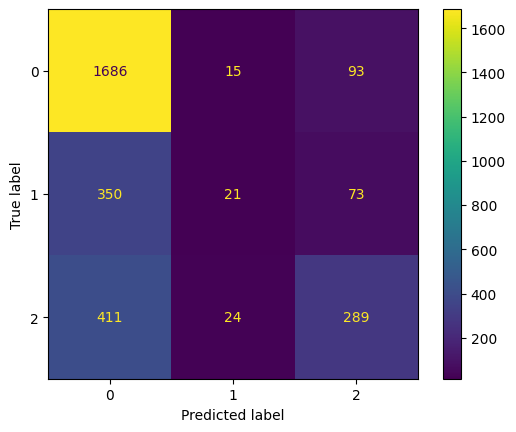

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()